In [ ]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import nn
from torch import optim
import matplotlib.pyplot as plt

In [ ]:
class MyDataset(Dataset):
  def __init__(self, size=5000, dim=40, random_offset=0):
        super(MyDataset, self).__init__()
        self.size = size
        self.dim = dim
        self.random_offset = random_offset

  def __getitem__(self, index):
      if index >= len(self):
          raise IndexError("{} index out of range".format(self.__class__.__name__))

      rng_state = torch.get_rng_state()
      torch.manual_seed(index + self.random_offset)

      while True:
        img = torch.zeros(self.dim, self.dim)
        dx = torch.randint(-10,10,(1,),dtype=torch.float)
        dy = torch.randint(-10,10,(1,),dtype=torch.float)
        c = torch.randint(-20,20,(1,), dtype=torch.float)

        params = torch.cat((dy/dx, c))
        xy = torch.randint(0,img.shape[1], (20, 2), dtype=torch.float)
        xy[:,1] = xy[:,0] * params[0] + params[1]

        xy.round_()
        xy = xy[ xy[:,1] > 0 ]
        xy = xy[ xy[:,1] < self.dim ]
        xy = xy[ xy[:,0] < self.dim ]

        for i in range(xy.shape[0]):
          x, y = xy[i][0], self.dim - xy[i][1]
          img[int(y), int(x)]=1
        if img.sum() > 2:
          break

      torch.set_rng_state(rng_state)
      return img.unsqueeze(0), params

  def __len__(self):
      return self.size

train_data = MyDataset()
val_data = MyDataset(size=500, random_offset=33333)
test_data = MyDataset(size=500, random_offset=99999)

tensor([-1., 17.])


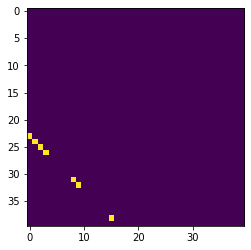

tensor([  1., -15.])


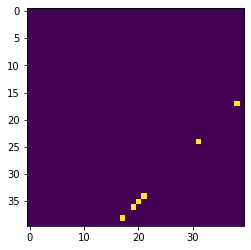

In [ ]:
for i in range(0, 2):
  img, par = train_data.__getitem__(i)
  print(par)
  imgplot = plt.imshow(img[0, :, :])
  plt.show()

In [ ]:
def train_val_plot(loss_plot, val_loss_plot, name):
    print("Final training loss: ", loss_plot[len(loss_plot)-1])
    print("Final validation loss: ", val_loss_plot[len(val_loss_plot)-1])
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))
    #plt.tight_layout()
    ax.plot(loss_plot, label="Training Loss")
    ax.plot(val_loss_plot, label="Validation Loss")
    ax.legend(fontsize=18)
    ax.grid(True)
    ax.set_ylim(bottom=0)
    ax.set_title(name + " Training/Validation Loss", fontsize=20);
    ax.set_xlabel("Epoch", fontsize=18);
    ax.set_ylabel("Loss", fontsize=18);
    plt.savefig(name + "_Training.png", format='png', dpi=1200)
    plt.show()

In [ ]:
def train_model(model, criterion, optimizer, num_epochs, name):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float("Inf")

    loss_plot= []
    val_loss_plot = []
    for epoch in range(num_epochs):
        # print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        # print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    #_, preds = torch.max(outputs, 1)
                    # Next two lines enable us to use Binary Crossentropy
                    #outputs = outputs.squeeze(1)
                    #loss = criterion(outputs, labels)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / dataset_sizes[phase]
            
            if phase == 'train':
                loss_plot.append(epoch_loss)
            else:
                val_loss_plot.append(epoch_loss)

            # print('{} Loss: {:.4f}'.format(
            #     phase, epoch_loss))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        # print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_loss))

    # loading best model weights
    model.load_state_dict(best_model_wts)
    train_val_plot(loss_plot, val_loss_plot, name)
    return model

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 48, (3, 3), stride=1, padding=1)
        self.fc1 = nn.Linear(76800, 128)
        self.fc2 = nn.Linear(128, 2)
            
    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(out)
        out = out.view(out.shape[0], -1)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        return out

Training complete in 5m 32s
Best val Loss: 12.936635
Final training loss:  1.28923176279068
Final validation loss:  13.831819793701172


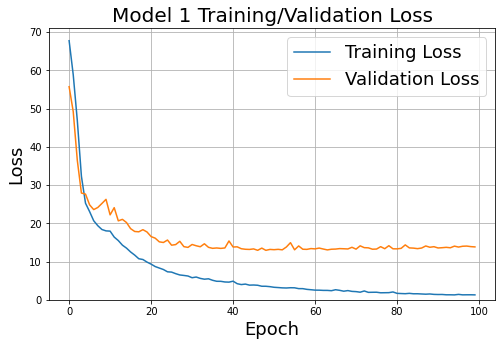

SimpleCNN(
  (conv1): Conv2d(1, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=76800, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

In [ ]:
import time
import copy

# PyTorch Loss Functions: https://medium.com/udacity-pytorch-challengers/a-brief-overview-of-loss-functions-in-pytorch-c0ddb78068f7

trainloader = DataLoader(train_data, batch_size=128, shuffle=True)
valloader = DataLoader(val_data, batch_size=128, shuffle=True)
testloader = DataLoader(test_data, batch_size=128, shuffle=True)
dataloaders = {'train': trainloader, 'val': valloader}
dataset_sizes = {'train': len(trainloader.dataset), 'val': len(valloader.dataset)}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# build the model
model = SimpleCNN()
if torch.cuda.is_available():
    model.cuda()
criterion = torch.nn.MSELoss()
optimizer_ft = optim.Adam(model.parameters())
train_model(model, criterion, optimizer_ft, num_epochs=100, name="Model 1")

In [ ]:
def test_model(model, testloader):
    model.eval()
    if torch.cuda.is_available():
        model.cuda()
    running_loss = 0.0
    for x, y in testloader:
        x, y = x.cuda(), y.cuda()
        outputs = model(x)
        loss = criterion(outputs, y)
        # statistics
        running_loss += loss.item() * x.size(0)
    overall_loss = running_loss / len(testloader.dataset)
    print('Test Loss: %2.2f' % overall_loss)
    
test_model(model, testloader)

Test Loss: 15.63


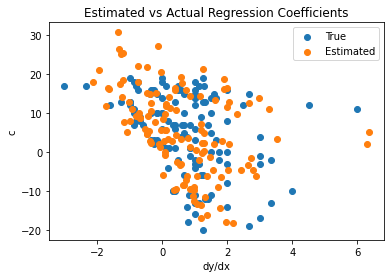

In [ ]:
def compare_coefficients(model, testloader):
      model.eval()
      if torch.cuda.is_available():
          model.cuda()
      for x, y in testloader:
          outputs = model(x.cuda())
          plt.title("Estimated vs Actual Regression Coefficients")
          plt.scatter(y[:,0].cpu().detach().numpy(), 
                      y[:,1].cpu().detach().numpy(), label='True')
          plt.scatter(outputs[:,0].cpu().detach().numpy(), 
                      outputs[:,1].cpu().detach().numpy(), label='Estimated')
          plt.xlabel("dy/dx")
          plt.ylabel("c")
          plt.legend()
          plt.show()

          break

compare_coefficients(model, testloader)

Original Regression Parameters (dy/dx, c):  0.6666667 10.0
Estimated Regression Parameters (dy/dx, c):  -0.3822385 14.86689


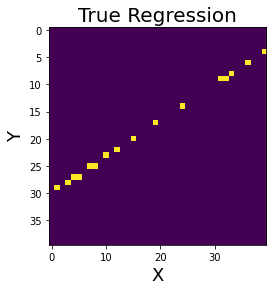

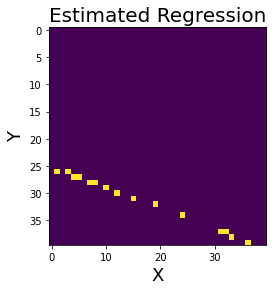

In [ ]:
def pred_line(model, testloader):
      model.eval()
      if torch.cuda.is_available():
          model.cuda()
      running_loss = 0.0
      for x, y in testloader:
          dim = 40
          img = torch.zeros(dim, dim)
          y_hat = model(x.cuda())
          xy = torch.randint(0,img.shape[1], (20, 2), dtype=torch.float)
          dy_dx, c = y[0, 0].cpu(), y[0, 1].cpu()
          print("Original Regression Parameters (dy/dx, c): ", 
                dy_dx.numpy(), c.numpy())
          print("Estimated Regression Parameters (dy/dx, c): ",
                y_hat[0, 0].cpu().detach().numpy(), 
                y_hat[0, 1].cpu().detach().numpy())
          xy[:,1] = xy[:,0] * dy_dx + c
          xy.round_()
          xy = xy[ xy[:,1] > 0 ]
          xy = xy[ xy[:,1] < dim ]
          xy = xy[ xy[:,0] < dim ]

          for i in range(xy.shape[0]):
            x, y = xy[i][0], dim - xy[i][1]
            img[int(y), int(x)]=1
          if img.sum() > 2:
            img2 =  img.unsqueeze(0) 
            plt.imshow(img2[0, :, :])
            plt.title("True Regression", fontsize=20)
            plt.xlabel("X", fontsize=18)
            plt.ylabel("Y", fontsize=18)
            plt.savefig("True_Regression.png", format='png', dpi=1200)
            plt.show()
            img = torch.zeros(dim, dim)
            dy_dx, c = y_hat[0, 0].cpu(),y_hat[0, 1].cpu()
            xy[:,1] = xy[:,0] * dy_dx + c
            xy.round_()
            xy = xy[ xy[:,1] > 0 ]
            xy = xy[ xy[:,1] < dim ]
            xy = xy[ xy[:,0] < dim ]

            for i in range(xy.shape[0]):
              x, y = xy[i][0], dim - xy[i][1]
              img[int(y), int(x)]=1
            if img.sum() > 2:
              img2 =  img.unsqueeze(0)
              plt.imshow(img2[0, :, :])
              plt.title("Estimated Regression", fontsize=20)
              plt.xlabel("X", fontsize=18)
              plt.ylabel("Y", fontsize=18)
              plt.savefig("Estimated_Regression.png", format='png', dpi=1200)
              plt.show()
          break

pred_line(model, testloader)

A Second Attempt

In [ ]:
class SimpleCNN2(nn.Module):
    def __init__(self):
        super(SimpleCNN2, self).__init__()
        self.conv1 = nn.Conv2d(1, 48, (3, 3), stride=1, padding=1)
        self.conv2 = nn.Conv2d(48, 48, (3, 3), stride=1, padding=1)
        self.fc1 = nn.Linear(48, 128)
        self.fc2 = nn.Linear(128, 2)
            
    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(out)
        out = self.conv2(out)
        out = F.relu(out)
        m = nn.AdaptiveMaxPool2d(output_size=(1,1))
        out = m(out)
        #out = F.adaptive_max_pool2d(out, output_size=(1,1))
        #out = F.max_pool2d(out, (40,40))
        out = out.view(out.shape[0], -1)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        return out

Training complete in 6m 5s
Best val Loss: 11.117902
Final training loss:  12.001011238861084
Final validation loss:  11.299320068359375


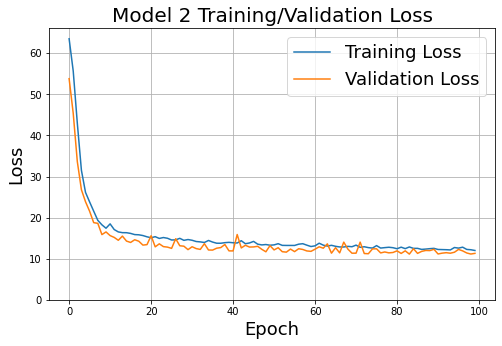

Test Loss: 14.19


In [ ]:
# build the model
model2 = SimpleCNN2()
if torch.cuda.is_available():
    model2.cuda()
criterion = torch.nn.MSELoss()
optimizer_ft = optim.Adam(model2.parameters())
train_model(model2, criterion, optimizer_ft, num_epochs=100, name="Model 2")
test_model(model2, testloader)

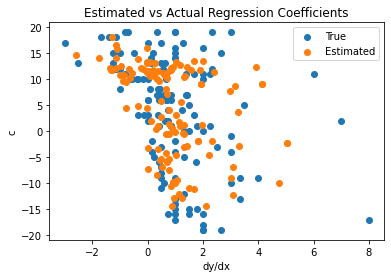

In [ ]:
compare_coefficients(model2, testloader)

Original Regression Parameters (dy/dx, c):  2.6666667 -2.0
Estimated Regression Parameters (dy/dx, c):  3.0748188 -6.836298


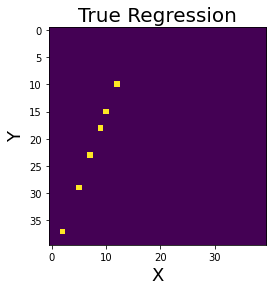

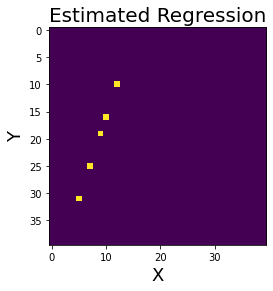

In [ ]:
pred_line(model2, testloader)

A Third Attempt

In [ ]:
class SimpleCNN3(nn.Module):
    def __init__(self):
        super(SimpleCNN3, self).__init__()
        self.conv1 = nn.Conv2d(3, 48, (3, 3), stride=1, padding=1)
        self.conv2 = nn.Conv2d(48, 48, (3, 3), stride=1, padding=1)
        self.fc1 = nn.Linear(48, 128)
        self.fc2 = nn.Linear(128, 2)
            
    def forward(self, x):
        idxx = torch.repeat_interleave(torch.arange(-20,20,dtype=torch.float).unsqueeze(0)/40.0, repeats=40, dim=0).to(x.device)
        idxy = idxx.clone().t()
        idx = torch.stack([idxx,idxy]).unsqueeze(0)
        idx = torch.repeat_interleave(idx, repeats=x.shape[0], dim=0)
        x = torch.cat([x,idx], dim=1)
        out = self.conv1(x)
        out = F.relu(out)
        out = self.conv2(out)
        out = F.relu(out)
        m = nn.AdaptiveMaxPool2d(output_size=(1,1))
        out = m(out)
        out = out.view(out.shape[0], -1)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        return out

Training complete in 6m 4s
Best val Loss: 1.158487
Final training loss:  1.2174017711639404
Final validation loss:  1.2028806133270264


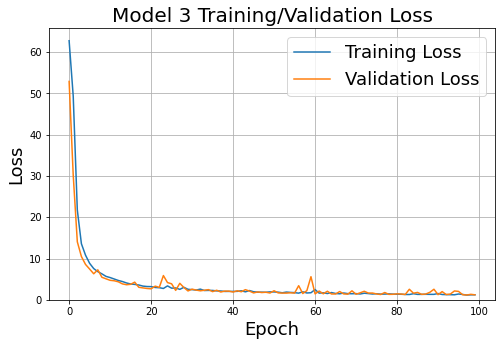

Test Loss: 1.66


In [ ]:
# build the model
model3 = SimpleCNN3()
if torch.cuda.is_available():
    model3.cuda()
criterion = torch.nn.MSELoss()
optimizer_ft = optim.Adam(model3.parameters())
train_model(model3, criterion, optimizer_ft, num_epochs=100, name="Model 3")
test_model(model3, testloader)

Original Regression Parameters (dy/dx, c):  -0.25 10.0
Estimated Regression Parameters (dy/dx, c):  -0.13261718 7.8981605


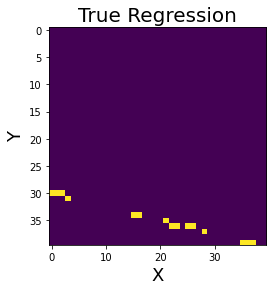

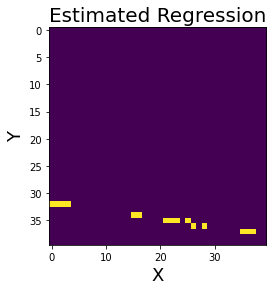

In [ ]:
pred_line(model3, testloader)

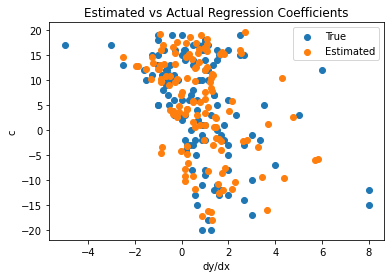

In [ ]:
compare_coefficients(model3, testloader)